##### In this notebook we will try to group the whole code into functions so that it is possible to visualize the frontal probabilities map for both the reanalysis data and the MUR data using the BOA algorithm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import xarray as xr
import os
from pathlib import Path
from numpy import nanmedian
import scipy
import scipy.signal
import math
from numpy.fft import fft2
import cmocean
import matplotlib
plt.rcParams["figure.figsize"] = 10, 8
%matplotlib inline

# ----------------------------------------------------------------------------------------------------------
### Functions for the BOA algorithm

Estas são as funções que foram convertidas de R para Python (filt5, filt3 e boa)

In [2]:
def filt5(lon, lat, ingrid, nodata=np.nan):
    """
    Find peaks in 5 directions. Flag as 5
    Finds maximum of a 5x5 sliding window. If the central pixel is the maximum, this is flagged as a one.
    All other pixels are flagged as zero.
    """
    
    nodatidx = ingrid.flatten()*np.nan ## creates single dim array with as much values as the matrix ingrid, with NANs
    outgrid = np.zeros(ingrid.shape)   ## outgrid is a matrix with the shape of ingrid, full of Zeros

    l1 = len(lat)
    l2 = len(lon)

    
    for i in range(3, l1-1):   
        for j in range(3, l2-1):
            subg = ingrid[(i-3):(i+2), (j-3):(j+2)] # return the last 5 rows of the last 5 columns of the matrix
            if np.isnan(subg).sum()==25:    #if all values in submatrix subg are null values:
                outgrid[i,j] = 0
            else:
                vec = np.array(subg).T.flatten()    # array with values of the transpose subg matrix
                ma = np.argmax(subg.flatten())      # index with the maximum value of subg array
                mi = np.argmin(subg.flatten())      # index with the minimum value of subg array
                
                if ma==12 or mi==12:     #se ma or mi se tratar do valor meio da matrix 5x5 (if the central pixel is the maximum)
                    outgrid[i-1,j-1] = 1      #flagged as 1
                else:
                    outgrid[i-1,j-1] = 0      #all other pixels are flagged as 0
    
    return outgrid

In [3]:
def filt3(lon, lat, ingrid, grid5):
    """
    Find peaks in 3 directions. FLag as 3
    Returns a median smoothed grid of satellite data
    """
    
    outgrid = ingrid*0   # matrix of 0s with shape of ingrid matrix
    l1 = len(lat)
    l2 = len(lon)
    
    for i in range(3, l1-1):   
        for j in range(3, l2-1):
            if (grid5[i,j]==0):
                subg = ingrid[(i-2):(i+1), (j-2):(j+1)]       # submatrix subg (3x3) 
                if np.isnan(subg).sum()==9:                   # if all values in submatrix subg (3x3) are null values:
                    outgrid[i-1,j-1] = ingrid[i-1,j-1]
                else:
                    vec = np.array(subg).T.flatten()          # array with values of the transpose subg matrix
                    ma = np.argmax(subg.flatten())            # index with the maximum value of subg array
                    mi = np.argmin(subg.flatten())            # index with the minimum value of subg array
                    
                    if (ma==4 or mi==4):                      #se ma or mi se tratar do valor meio da matrix 3x3
                        outgrid[i-1,j-1] = nanmedian(subg)    # median while ignoring NaNs.
                    else:
                        outgrid[i-1,j-1] = ingrid[i-1,j-1]
            
            else:
                outgrid[i-1,j-1] = ingrid[i-1,j-1]
                
    return outgrid

In [4]:
def boa(lon, lat, ingrid, nodata = np.nan, direction = False):
    
    def filter2(x, filt):
        """
        Workhorse filter from EBImage. Modified so we don't need colorspace and other annoying requirements ????
        """
        
        dx = x.shape                          
        df = filt.shape  
        
        if (df[0]//2 == 0) or (df[1]//2 == 0):
            sys.exit('dimensions of "filter" matrix must be odd')
        if (dx[0] < df[0]) or (dx[1] < df[1]):
            sys.exit("dimensions of 'x' must be bigger than 'filter'")
            
        cx = tuple(elem//2 for elem in dx)    
        cf = tuple(elem//2 for elem in df)    

        wf = np.zeros(shape=dx)       #matrix with zeros with shape of x

        wf[cx[0]-cf[0]-1:cx[0]+cf[0], cx[1]-cf[1]-1:cx[1]+cf[1]] = filt    #colocar valores de filt nos meio da matriz wf

        wf = fft2(wf)         #apply the 2 dimensional discrete fourier transform                  
    
        dim_x = np.array(dx[0:2])
        dim_x =np.append(dim_x, math.prod(dx)/math.prod(dx[0:2]))     

        aux1 = np.arange(cx[0],dx[0]+1)
        aux2 = np.arange(1,cx[0])
        index1 = np.concatenate((aux1, aux2), axis=None)  
        index1 = index1-1   

        aux3 = np.arange(cx[1], dx[1]+1)
        aux4 = np.arange(1,cx[1])
        index2 = np.concatenate((aux3, aux4), axis=None) 
        index2 = index2-1   
        
        #estes index vao ser usados para reordenar valores da matriz y
        
        y = (scipy.fft.ifft2(scipy.fft.fft2(x)*wf)).real

        y = np.array([[y[i][j] for j in index2] for i in index1])
        
        return y
    
#======================================================#
# Main BOA algorithm                                   
#======================================================#      
    gx = np.matrix([[-1,0,1],[-2,0,2],[-1,0,1]])        #filter in x
    gy = np.matrix([[1,2,1],[0,0,0],[-1,-2,-1]])        #filter in y
        
    np.nan_to_num(ingrid, nan=-9999, posinf=-9999, neginf=-9999) ##replace NaN and inf values with -9999
        
    grid5 = filt5(lon, lat, ingrid, nodata = nodata)
    grid35 = filt3(lon, lat, ingrid, grid5)

    # make an index of bad values and land pixels.
    grid35 = grid35.astype("float")
    grid35[grid35 == -9999]=np.nan
    naidx = np.isnan(grid35)        #matriz com dimensões de grid35 (True se valor for nan, False caso contrario)
    # convert these (True values of naidx) to zeros (in grid35) for smoothing purposes
    grid35[naidx]=0  

    # perform the smoothing (Sobel filter)  
    tgx = filter2(grid35, gx)
    tgy = filter2(grid35, gy)
        
    tx = tgx/np.nansum(abs(np.array(gx).flatten()))    #tgx a dividir pela soma dos valores absolutos do filtro gx
    ty = tgy/np.nansum(abs(np.array(gy).flatten()))    #tgy a dividir pela soma dos valores absolutos do filtro gy
    front = np.sqrt((tx**2)+(ty**2))                   #front é raiz quadrada da soma dos quadrados dos valores de tx e ty


#======================================================#
# landmask and edge dilation
#======================================================#

    land = naidx*1
    land = land.astype("float")

    land[land==1] = np.nan
    land[~np.isnan(land)] = 1

    
#======================================================#
# landmask and edge dilation using raster!
#======================================================#

    l2=lon.size    #using size because lon and lat are matrices
    l1=lat.size

    midx = land*np.nan

    midx[5:(l1-2), 5:(l2-2)] = 1

    land = np.multiply(land, midx)
    
    
    ssr = np.flip(front.T, 0)
    

    #Apply a sliding window kernell to the land matrix
    mask = scipy.signal.convolve2d(np.flip(land.T, 0), np.array([0,0,0,0,1,0,0,0,0]).reshape(3,3), boundary='symm', mode='same')

    matrix_front =  mask * np.flip(front.T, 0)   #matrix of mask raster file * matrix of ssr raster file


    
    if direction==True:
#   ************************************
#   *** Calculate Gradient Direction ***
#   ************************************
        
        n = ingrid.size       #nr os elements of the grid matrix
        grid_shape = ingrid.shape

        GRAD_DIR = np.zeros(n)     #matrix of zeros with shape of ingrid matrix

        for i in range(n):
            GRAD_DIR[i] = math.atan2(tgy.flatten()[i], tgx.flatten()[i])
    
        GRAD_DIR = GRAD_DIR*180/math.pi    # change radians to degrees

        OK = np.where(GRAD_DIR < 0)

        OK = np.array(OK)

        if OK.size >1:
            GRAD_DIR[OK] = 360 - abs(GRAD_DIR[OK])    #Adjust to 0-360 scheme (make negative degrees positive)
    
        GRAD_DIR = (360 - GRAD_DIR + 90) % 360     #Convert degrees so that 0 degrees is North and East is 90 degrees
        GRAD_DIR = GRAD_DIR.reshape(grid_shape)
        
        
        grad_dir = np.flip(GRAD_DIR.T, 0)


        # create array grdir (result from multiplication of grad_dir_matrix and mask_matrix (its the conv matrix))
        grdir_matrix = np.flip(GRAD_DIR.T, 0)*mask


        #No R eles pôem numa named_list por isso aqui pus num dicionário (algo equivalente)
        dic = {'grdir': grdir_matrix, 'front': matrix_front}
        
    else:
        matrix_front

        
    return matrix_front

# -----------------------------------------------------------------------------------------------------------

### BOA pipeline

Nesta parte serão definidas as funções e o código para que seja possivel implementar o algoritmo BOA a diferentes datasets (no nosso caso serão os dados de modelo (Reanálise) e do MUR)

In [5]:
def get_data(data):
    
    """
    function to get our netCDF file that is stored in the data directory and convert it to a dataframe.
    The data parameter is the string name of the netCDF file we want to import
    """
    
    current_path = os.getcwd()
    data_folder = os.path.join(current_path,"../data")
    
    nc_path = os.path.join(data_folder, data)
    ds = nc.Dataset(nc_path)
    netCDF = xr.load_dataset(nc_path)
    
    df = netCDF.to_dataframe()
    df = df.reset_index()
    
    df = df.drop(['depth'], axis=1, errors='ignore') #drop the column 'depth' if exists: only exists in reanalysis
    
    #caso se esteja a importar os dados do MUR, renomear as colunas e passar a temperatura para Celsius
    if data.startswith('mur'):
        df.rename(columns={'lat': 'latitude', 'lon': 'longitude', 'time': 'time', 'analysed_sst':'thetao'}, inplace=True)
        df['thetao'] = df['thetao']-273.15   
        
    
    return df

In [6]:
#Importar o netCDF dos dados de reanalise e converte-los para uma dataframe
df_reanalysis = get_data('IBI2014-2019.nc')

In [7]:
#Importar o netCDF dos dados do MUR e converte-los para uma dataframe
df_mur_sept = get_data('murSept2019.nc')

In [8]:
df_mur_aug = get_data('murAugust2019.nc')

In [9]:
df_mur_july = get_data('murJuly2019.nc')

In [7]:
def get_period(df):
    
    """
    Function that receives a dataframe with data of SST relative to different days 
    and returns a dictionaire of dataframes (for each different day) and an array with the different dates 
    its possible to find in our dataframe 
    """
    
    specificday = [pd.Timestamp(dd).strftime("%Y-%m-%d %H:%M:%S") for dd in df['time'].unique()]
    specificday = np.array(specificday, dtype=np.object)
  
    #create a dictionary to store the data frames for each day
    days = {elem : pd.DataFrame for elem in specificday}

    for key in days.keys():
        days[key] = df[:][df['time'] == key]
        
    return days, specificday

#after this function we only have to define the period we want to analyse

In [11]:
days_mur_set, specificday_mur_set = get_period(df_mur_sept)
#days_mur -> dictionaire of dataframes for each day of the MUR data
#specificday_mur -> array with the different dates that are in the data in question

In [12]:
days_mur_aug, specificday_mur_aug = get_period(df_mur_aug)

In [13]:
days_mur_july, specificday_mur_july = get_period(df_mur_july)

In [8]:
days_r, specificday_r = get_period(df_reanalysis)

##### Define the period we want to analyse

In [33]:
set2019_mur = specificday_mur_set[(specificday_mur_set >='2019-09-01 09:00:00') & (specificday_mur_set<='2019-09-30 09:00:00')]

In [9]:
summer_r = specificday_r[(specificday_r >='2019-07-01 12:00:00') & (specificday_r<='2019-09-30 12:00:00')]
#dates for the days of september 2019

In [35]:
set15_2019_mur = specificday_mur_set[(specificday_mur_set =='2019-09-15 09:00:00')]

In [36]:
set15_2019_r = specificday_r[(specificday_r =='2019-09-15 12:00:00')]

In [37]:
set10_2019_mur = specificday_mur_set[(specificday_mur_set =='2019-09-10 09:00:00')]

In [38]:
set10_2019_r = specificday_r[(specificday_r =='2019-09-10 12:00:00')]

In [10]:
def BOA_aplication(df):  
    
    """
    Função para que, para uma dada dataframe retorne a aplicação do BOA para um certo dia
    """
    
    lat = np.array(df['latitude'].unique())
    lon = np.array(df['longitude'].unique())
    ingrid = np.array(df['thetao']).reshape(len(lat), len(lon))
    
    front = boa(lon=lon, lat=lat, ingrid=ingrid, nodata = np.nan, direction = False)
    front = np.flip(front, axis=0)
    front = np.array([[front[j][i] for j in range(len(front))] for i in range(len(front[0])-1,-1,-1)])
    
    return front

In [11]:
def frontal_prob_boa(period, df, MUR=False):
    """
    Função que retorna um array de shape com a frontal probability de cada pixel
    """
    #if statment to define array shape based on which data it is
    if MUR==False:
        fp = np.zeros((121,169))
    elif MUR==True: 
        fp = np.zeros((1001,1401))
        
    for day in period:
        fp = fp + BOA_aplication(df[day])
    
    fp = fp/(len(period))     #para o calculo da FP vai dividir-se pelo numero de periodos (dias) em questão
    
    return fp

In [12]:
def BOA_visualization(period, df, MUR, vmin=None, vmax=None):
    
    """
    Função para visualizar o map of frontal probability e um histograma com as frontal probabilities
    """
    
    fp = frontal_prob_boa(period=period, df=df, MUR=MUR)
    
    #fp=jas_data[Tmax]
    
    lat = np.array(df[period[0]]['latitude'].unique())
    lon = np.array(df[period[0]]['longitude'].unique())
    
    
    plt.rcParams["figure.figsize"] = (15, 25)
    fig = plt.figure()
    ax1 = fig.add_subplot(2,1,1)
    img = ax1.imshow(fp, cmocean.cm.thermal, vmin=vmin, vmax=vmax, extent=[lon[0], lon[-1], lat[0], lat[-1]])
    #extent serve para definir a extensão do eixo dos x e dos y
    plt.colorbar(img, orientation='horizontal', fraction=0.025, pad=0.08, aspect=50)
    plt.title("Map of frontal probability", fontsize=20)

    ax2 = fig.add_subplot(2,1,2)
    ax2.hist(fp.flatten(), bins=100);
    plt.xlabel('Frontal Probability',fontsize=10)

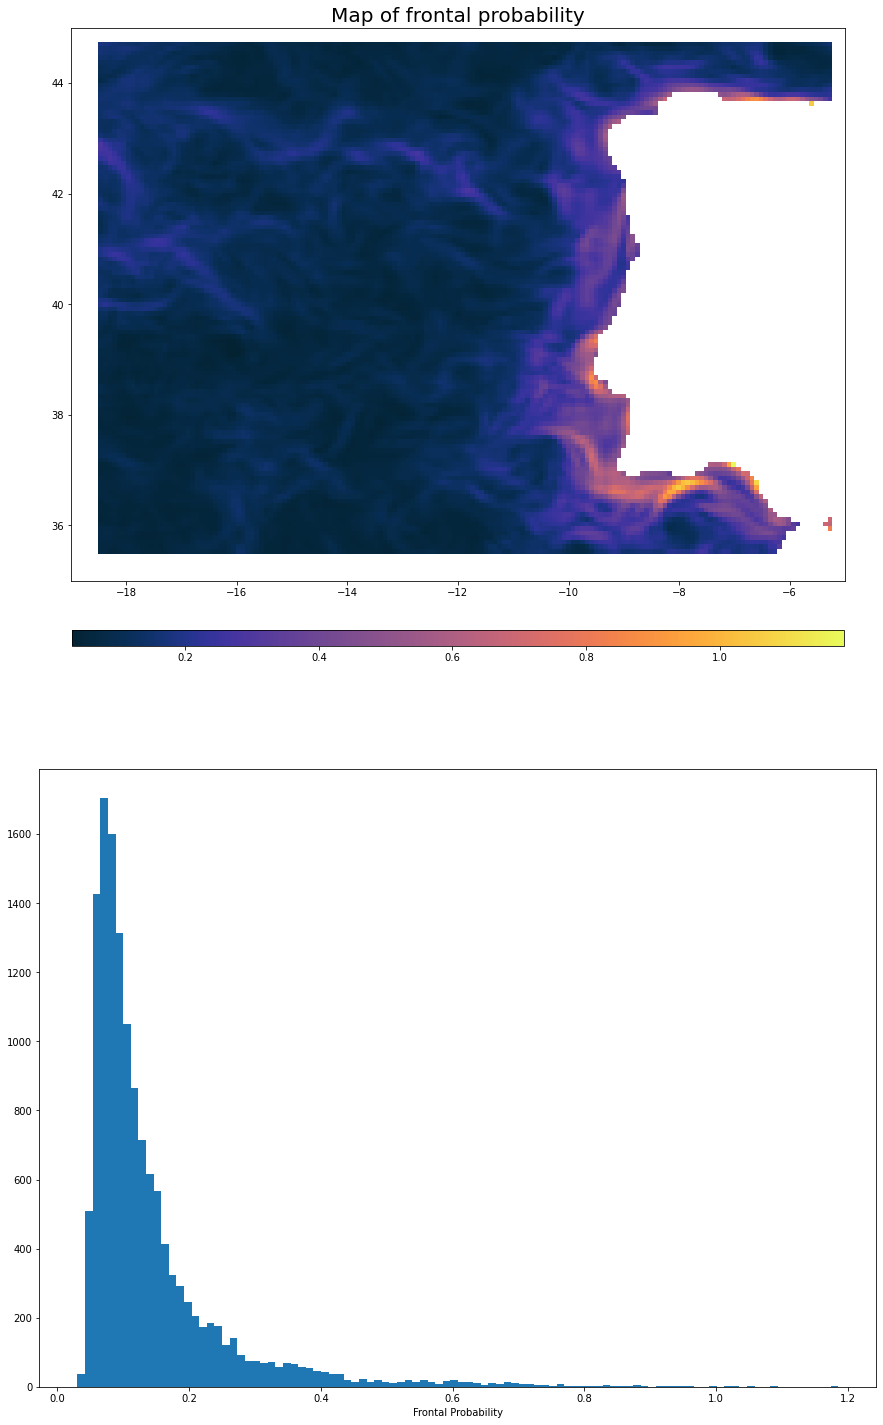

In [14]:
BOA_visualization(period=summer_r, df=days_r, MUR=False)

##### Para agregar os varios netCDFs dos dados do MUR e aplicar-lhe o algoritmo

In [37]:
def Merge(dict1, dict2):
    """
    Function to merge 2 dictionaires
    """
    
    res = {**dict1, **dict2}
    return res

In [38]:
days_mur_augSet = Merge(days_mur_aug, days_mur_set)

In [40]:
days_mur_summer = Merge(days_mur_july, days_mur_augSet)

In [41]:
days_mur_summer

{'2019-07-01 09:00:00':           latitude  longitude                time     thetao
 0             35.0 -19.000000 2019-07-01 09:00:00  21.459015
 31            35.0 -18.990000 2019-07-01 09:00:00  21.488007
 62            35.0 -18.980000 2019-07-01 09:00:00  21.506012
 93            35.0 -18.969999 2019-07-01 09:00:00  21.509003
 124           35.0 -18.959999 2019-07-01 09:00:00  21.502991
 ...            ...        ...                 ...        ...
 43474276      45.0  -5.040000 2019-07-01 09:00:00  17.605988
 43474307      45.0  -5.030000 2019-07-01 09:00:00  17.605988
 43474338      45.0  -5.020000 2019-07-01 09:00:00  17.602997
 43474369      45.0  -5.010000 2019-07-01 09:00:00  17.596985
 43474400      45.0  -5.000000 2019-07-01 09:00:00  17.588989
 
 [1402401 rows x 4 columns],
 '2019-07-02 09:00:00':           latitude  longitude                time     thetao
 1             35.0 -19.000000 2019-07-02 09:00:00  21.085999
 32            35.0 -18.990000 2019-07-02 09:00:00  21.

In [44]:
specificday_mur_summer = np.concatenate([specificday_mur_july, specificday_mur_aug, specificday_mur_set])

In [45]:
specificday_mur_summer

array(['2019-07-01 09:00:00', '2019-07-02 09:00:00',
       '2019-07-03 09:00:00', '2019-07-04 09:00:00',
       '2019-07-05 09:00:00', '2019-07-06 09:00:00',
       '2019-07-07 09:00:00', '2019-07-08 09:00:00',
       '2019-07-09 09:00:00', '2019-07-10 09:00:00',
       '2019-07-11 09:00:00', '2019-07-12 09:00:00',
       '2019-07-13 09:00:00', '2019-07-14 09:00:00',
       '2019-07-15 09:00:00', '2019-07-16 09:00:00',
       '2019-07-17 09:00:00', '2019-07-18 09:00:00',
       '2019-07-19 09:00:00', '2019-07-20 09:00:00',
       '2019-07-21 09:00:00', '2019-07-22 09:00:00',
       '2019-07-23 09:00:00', '2019-07-24 09:00:00',
       '2019-07-25 09:00:00', '2019-07-26 09:00:00',
       '2019-07-27 09:00:00', '2019-07-28 09:00:00',
       '2019-07-29 09:00:00', '2019-07-30 09:00:00',
       '2019-07-31 09:00:00', '2019-08-01 09:00:00',
       '2019-08-02 09:00:00', '2019-08-03 09:00:00',
       '2019-08-04 09:00:00', '2019-08-05 09:00:00',
       '2019-08-06 09:00:00', '2019-08-07 09:0

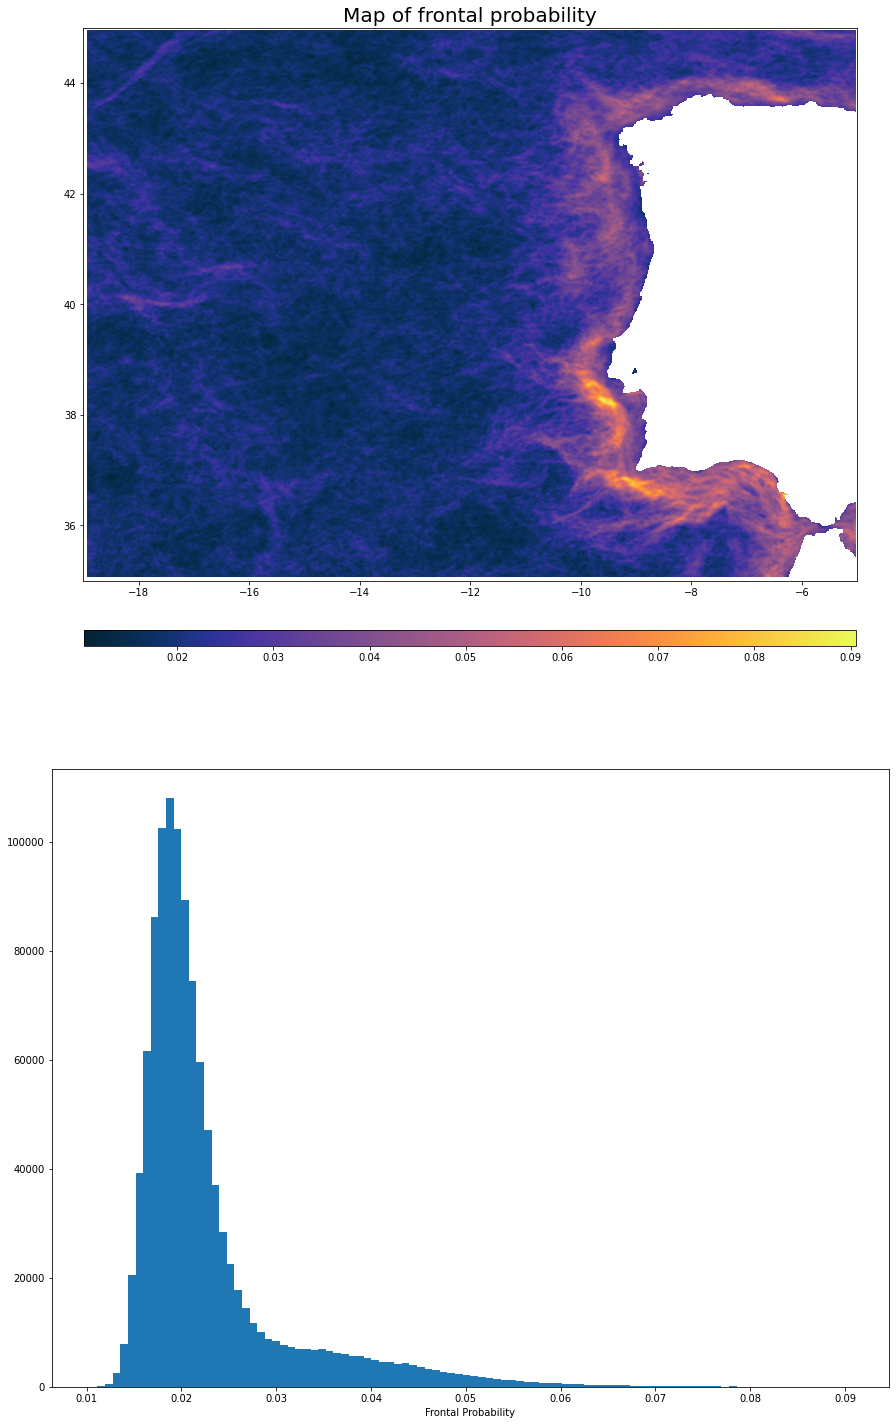

In [46]:
BOA_visualization(period=specificday_mur_summer, df=days_mur_summer, MUR=True)